In [1]:
# =========================================
# Step 1: Environment Setup & Data Loading
# =========================================
# Goal: Load dependencies and prepare the SemEval training data.

import os
import sys
import spacy.util
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eval_utils import pearson_corr
from sklearn.ensemble import RandomForestRegressor

# Ensure src/ is in the Python path
sys.path.append(os.path.abspath("src"))

# Check if the spacy model is already installed as a package
if not spacy.util.is_package("en_core_web_sm"):
    print("Model not found. Downloading 'en_core_web_sm'...")
    !{sys.executable} -m spacy download en_core_web_sm
else:
    print("'en_core_web_sm' is already downloaded.")

# Import local modules
from src.data_loader import load_sts_train, load_sts_test
from src.features import lexical_features, syntactic_features, combined_features
from src.models import (
    build_feature_matrix, train_val_split,
    make_ridge_model, make_svr_model, make_rf_model,
    fit_and_eval
)

# Load Training Data (MSRpar, MSRvid, SMTeuroparl)
print("Loading Training Data...")
train_df = load_sts_train("./train")
print(train_df["source"].value_counts())

'en_core_web_sm' is already downloaded.
--- Checking and Downloading Resources ---
Loading Training Data...
source
MSRpar         750
MSRvid         750
SMTeuroparl    734
Name: count, dtype: int64


In [2]:
# ====================================
# Step 2: Feature Matrix Construction
# ====================================
# Goal: Isolate Lexical and Syntactic features to test dimensions separately (Ablation).
# 1. X_lex: Surface-level similarity (Jaccard, Overlap)
# 2. X_syn: Structural similarity (Dependency Parsing)
# 3. X_comb: The full Ensemble (All features)

print("Extracting Features...")

# 1. Lexical (Baseline)
X_lex, y = build_feature_matrix(train_df, lexical_features)

# 2. Syntactic (TakeLab approach)
X_syn, _ = build_feature_matrix(train_df, syntactic_features)

# 3. Combined Ensemble (UKP + TakeLab approach)
# Includes: Lexical, WordNet, Syntax, Negation, N-grams, Entities, BLEU, LCS, Numbers, Stopwords
X_comb, _ = build_feature_matrix(train_df, combined_features)

# Create Train/Validation splits
X_lex_tr, X_lex_val, y_tr, y_val = train_val_split(X_lex, y)
X_syn_tr, X_syn_val, _, _       = train_val_split(X_syn, y)
X_comb_tr, X_comb_val, _, _     = train_val_split(X_comb, y)

print(f"Combined Feature Matrix Shape: {X_comb.shape}")

Extracting Features...
Combined Feature Matrix Shape: (2234, 15)


In [3]:
# =========================================
# Step 3: Model Selection & Ablation Study
# =========================================
# Goal: Compare algorithms (Ridge, SVR, RF) across feature sets using Cross-Validation.
# Note: We use the Validation Split here. Test data is not touched.

print("Training Models & Tuning Hyperparameters...")

results = []

# --- Train & Evaluate on Validation Set ---
# We test 3 algorithms x 3 feature sets to find the best configuration.

# 1. Lexical Only
_, p_ridge_lex = fit_and_eval(make_ridge_model(), X_lex_tr, y_tr, X_lex_val, y_val)
_, p_svr_lex   = fit_and_eval(make_svr_model(),   X_lex_tr, y_tr, X_lex_val, y_val)
_, p_rf_lex    = fit_and_eval(make_rf_model(),    X_lex_tr, y_tr, X_lex_val, y_val)
results.extend([("Ridge-Lex", p_ridge_lex), ("SVR-Lex", p_svr_lex), ("RF-Lex", p_rf_lex)])

# 2. Syntactic Only
_, p_ridge_syn = fit_and_eval(make_ridge_model(), X_syn_tr, y_tr, X_syn_val, y_val)
_, p_svr_syn   = fit_and_eval(make_svr_model(),   X_syn_tr, y_tr, X_syn_val, y_val)
_, p_rf_syn    = fit_and_eval(make_rf_model(),    X_syn_tr, y_tr, X_syn_val, y_val)
results.extend([("Ridge-Syn", p_ridge_syn), ("SVR-Syn", p_svr_syn), ("RF-Syn", p_rf_syn)])

# 3. Combined Ensemble
# This model represents the final configuration
best_ridge, p_ridge_comb = fit_and_eval(make_ridge_model(), X_comb_tr, y_tr, X_comb_val, y_val)
best_svr,   p_svr_comb   = fit_and_eval(make_svr_model(),   X_comb_tr, y_tr, X_comb_val, y_val)
best_rf,    p_rf_comb    = fit_and_eval(make_rf_model(),    X_comb_tr, y_tr, X_comb_val, y_val)
results.extend([("Ridge-Comb", p_ridge_comb), ("SVR-Comb", p_svr_comb), ("RF-Comb", p_rf_comb)])

# Show Validation Leaderboard
pd.DataFrame(results, columns=["Model", "Val_Pearson"]).sort_values("Val_Pearson", ascending=False)

Training Models & Tuning Hyperparameters...
[model] Best Params: {'model__alpha': 1.0}
[model] Best Params: {'model__C': 100.0, 'model__epsilon': 0.2, 'model__gamma': 'scale'}
[model] Best Params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
[model] Best Params: {'model__alpha': 10.0}
[model] Best Params: {'model__C': 1.0, 'model__epsilon': 0.2, 'model__gamma': 'scale'}
[model] Best Params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
[model] Best Params: {'model__alpha': 1.0}
[model] Best Params: {'model__C': 1.0, 'model__epsilon': 0.2, 'model__gamma': 0.1}
[model] Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 300}


,Model,Val_Pearson
7,SVR-Comb,0.832124
8,RF-Comb,0.832080
6,Ridge-Comb,0.728750
2,RF-Lex,0.728720
1,SVR-Lex,0.708024
5,RF-Syn,0.699326
4,SVR-Syn,0.675709
0,Ridge-Lex,0.606667
3,Ridge-Syn,0.492885


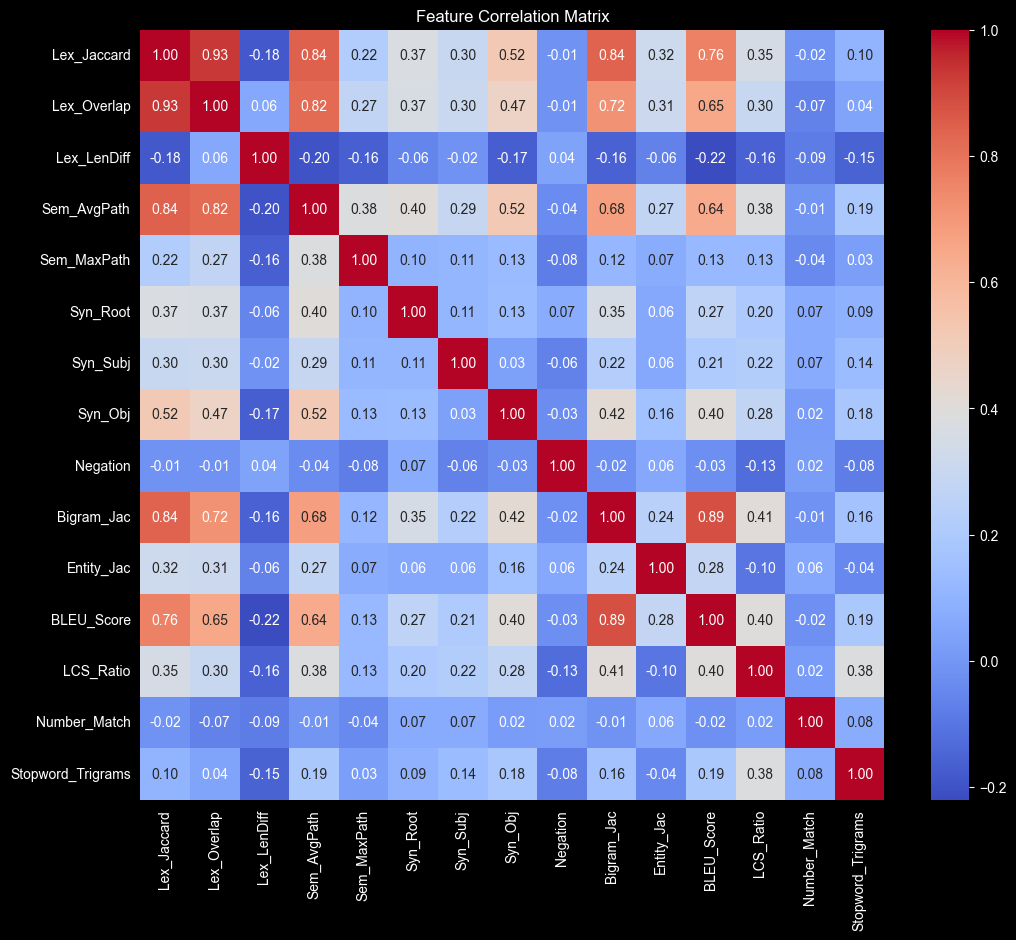

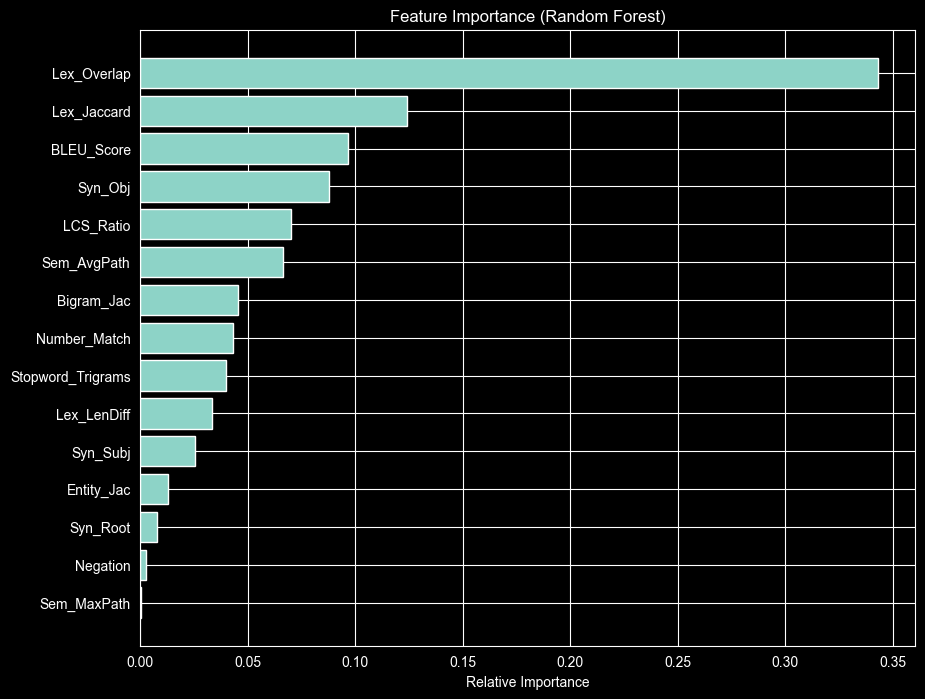

In [4]:
# ====================================
# Step 4: Feature Importance Analysis
# ====================================
# Goal: Interpretability. Which linguistic features actually drive the model's decisions?

# Feature Names  
feature_names = [
    # Lexical (3)
    "Lex_Jaccard", "Lex_Overlap", "Lex_LenDiff", 
    # Semantic (2)
    "Sem_AvgPath", "Sem_MaxPath",
    # Syntactic (3)
    "Syn_Root", "Syn_Subj", "Syn_Obj",
    # Domain Boosters (6)
    "Negation", "Bigram_Jac", "Entity_Jac",
    "BLEU_Score", "LCS_Ratio", "Number_Match",
    # Stylistic (1)
    "Stopword_Trigrams"
]

# 1. Feature Correlations
# Check if "Syntactic" features provide unique info compared to "Lexical"
df_feats = pd.DataFrame(X_comb_tr, columns=feature_names)
plt.figure(figsize=(12, 10))
sns.heatmap(df_feats.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# 2. Feature Importance
# See which features drove the decision (Expected: Numbers for MSRpar, Lexical for Videos)
if hasattr(best_rf, "feature_importances_"):
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importance (Random Forest)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [5]:
# ===========================================
# Step 5: Parsimony Check (Feature Selection)
# ===========================================
# Goal: Determine if we can reduce model complexity (drop features) without losing accuracy.

print("\n--- Feature Selection Experiment (Top-K) ---")

# 1. Get feature names and their importance from the Validation Model (Cell 3)
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort descending

results_fs = []
k_values = [3, 5, 10, 15] # Test these subset sizes

for k in k_values:
    # Select top k indices
    top_k_indices = indices[:k]

    # Slice the training and validation matrices (from Cell 2)
    X_tr_k = X_comb_tr[:, top_k_indices]
    X_val_k = X_comb_val[:, top_k_indices]

    # Retrain RF on this subset using params from Cell 3
    rf_k = RandomForestRegressor(**best_rf.get_params())
    rf_k.fit(X_tr_k, y_tr)

    # Evaluate
    val_pred = rf_k.predict(X_val_k)
    score = pearson_corr(y_val, val_pred)
    results_fs.append((f"Top-{k} Features", score))

# Display Results
df_fs = pd.DataFrame(results_fs, columns=["Subset", "Val_Pearson"])
print(df_fs)

# Interpretation
best_subset = df_fs.loc[df_fs['Val_Pearson'].idxmax()]
print(f"\nBest Subset: {best_subset['Subset']} (r={best_subset['Val_Pearson']:.4f})")


--- Feature Selection Experiment (Top-K) ---
            Subset  Val_Pearson
0   Top-3 Features     0.755725
1   Top-5 Features     0.767350
2  Top-10 Features     0.822444
3  Top-15 Features     0.832766

Best Subset: Top-15 Features (r=0.8328)


In [6]:
# ==========================================
# Step 6: Final Training & Blind Prediction
# ==========================================
# Goal: Retrain the best configuration (RF-Combined) on ALL training data.
# Then, generate predictions for the unseen 'test-gold' datasets.

print("Retraining Best Models on FULL Training Data...")

# Retrain the "Combined" Random Forest on all available training data
# (Random Forest usually handles the mix of features best)
final_model = make_rf_model() 
final_model.fit(X_comb, y)
best_estimator = final_model.best_estimator_

# Load Test Data (All 5 sets, including Surprise ones)
test_df = load_sts_test("test-gold")
print(f"Test Sets Loaded: {test_df['source'].unique()}")

# Build Features for Test Data
X_test_comb = build_feature_matrix(test_df, combined_features, has_score=False)

# Predict
test_df["predicted_score"] = best_estimator.predict(X_test_comb)

# Create output folder
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

# Write Output Files into 'output/' folder
for src in test_df["source"].unique():
    subset = test_df[test_df["source"] == src]
    
    # Construct path: output/STS.output.MSRpar.mySystem.txt
    filename = f"STS.output.{src}.mySystem.txt"
    out_path = os.path.join(output_dir, filename)
    
    subset["predicted_score"].to_csv(out_path, sep="\t", header=False, index=False)
    print(f"Generated: {out_path}")

Retraining Best Models on FULL Training Data...
Test Sets Loaded: ['MSRpar' 'MSRvid' 'SMTeuroparl' 'OnWN' 'SMTnews']
Generated: output/STS.output.MSRpar.mySystem.txt
Generated: output/STS.output.MSRvid.mySystem.txt
Generated: output/STS.output.SMTeuroparl.mySystem.txt
Generated: output/STS.output.OnWN.mySystem.txt
Generated: output/STS.output.SMTnews.mySystem.txt


In [7]:
# ==========================================
# Step 7: Official Evaluation
# ==========================================
# Goal: Run the official SemEval Perl script to calculate Pearson correlations.

!bash evaluate.sh

       RUNNING MACRO EVALUATION         
Dataset: MSRpar ... Pearson: 0.66083
Dataset: MSRvid ... Pearson: 0.83347
Dataset: SMTeuroparl ... Pearson: 0.44814
Dataset: OnWN ... Pearson: 0.66336
Dataset: SMTnews ... Pearson: 0.43389
Final Macro-Average Pearson: 0.60794

        OFFICIAL POOLED EVALUATION        
Pooled ALL Pearson: 0.75073
